In [380]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")

In [381]:
trading_symbols = np.array(['STXRAF.JO', 'CTOP50.JO','ETF5IT.JO', 'STXCHN.JO' ])
current_prices = []
for symbol in trading_symbols:
    stock = yf.Ticker(symbol)
    historical_data = stock.history(period= '2y')
    closing_prices = historical_data['Close']/100
    if not closing_prices.empty:
        current_price = closing_prices.iloc[-1]
        current_prices.append(current_price)
        print(f"Current price for {symbol}: {current_price}")
    else:
        print(f"Could not retrieve data for {symbol}")

Current price for STXRAF.JO: 31.49
Current price for CTOP50.JO: 42.0
Current price for ETF5IT.JO: 34.45
Current price for STXCHN.JO: 56.41


In [382]:
# satrix RAFI
stock = yf.Ticker('STXRAF.JO',)
historical_data = stock.history(period= '2y')
stock1 = historical_data/100
# 10x Top50 ETF
stock = yf.Ticker('CTOP50.JO')
historical_data = stock.history(period= '2y')
stock2 = historical_data/100
# invest s&p500 info tech index
stock = yf.Ticker('ETF5IT.JO')
historical_data = stock.history(period= '2y')
stock3 = historical_data/100
# satrix MSCI china
stock = yf.Ticker('STXCHN.JO')
historical_data = stock.history(period= '2y')
stock4 = historical_data/100

In [383]:
df = pd.DataFrame({'STXRAF.JO': stock1['Close'], 'CTOP50.JO': stock2['Close'], 'ETF5IT.JO': stock3['Close'], 'STXCHN.JO': stock4['Close']})

In [384]:
df.describe()

,STXRAF.JO,CTOP50.JO,ETF5IT.JO,STXCHN.JO
count,500.000000,500.000000,500.000000,500.000000
mean,24.168291,33.337211,27.667818,42.192972
std,2.389971,3.423124,3.750692,6.194618
min,20.654673,27.921462,19.235850,32.568701
25%,22.182176,30.130784,25.440000,36.658250
50%,23.837147,33.183944,27.825000,40.875000
75%,24.887634,34.932863,30.275000,48.222500
max,31.490000,42.250000,34.930000,57.080000


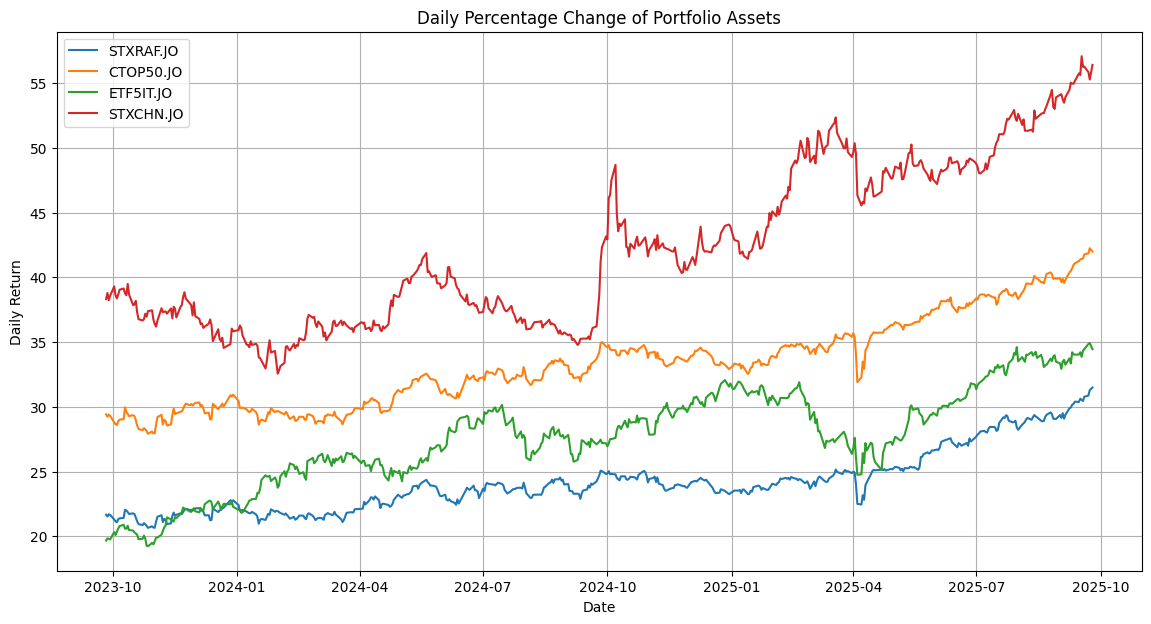

In [385]:
rolling = 10
plt.figure(figsize=(14,7))
plt.plot(df.index, df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Percentage Change of Portfolio Assets')
plt.legend(df.columns)
plt.show()

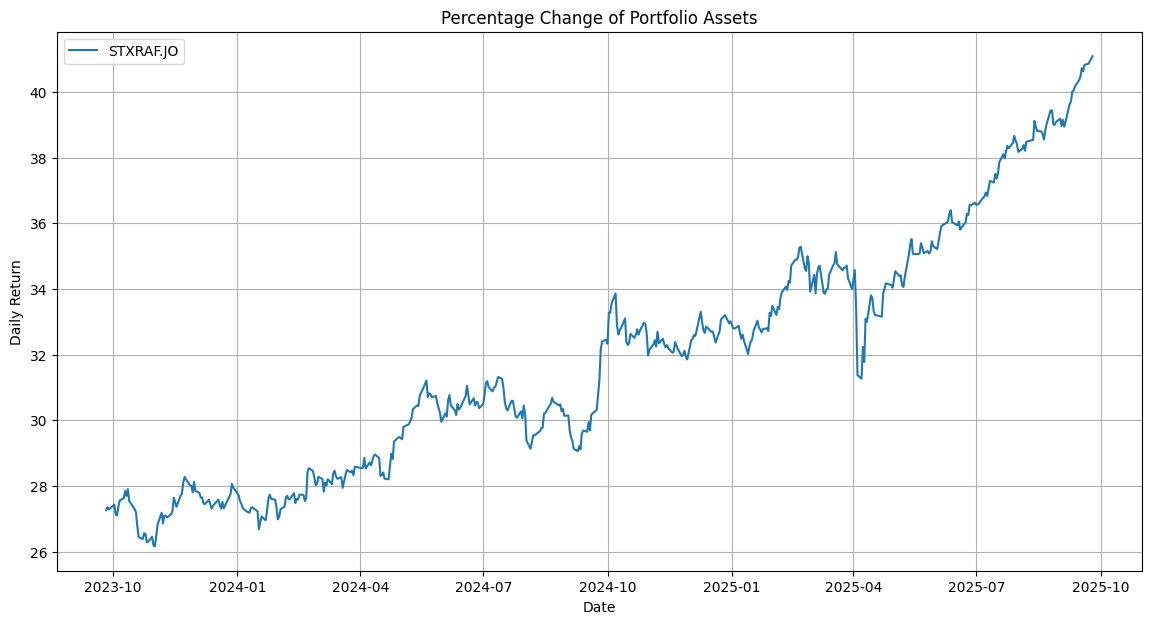

In [386]:
portfolio = (stock1 + stock2 + stock3+ stock4)/4
rolling = 10
plt.figure(figsize=(14,7))
plt.plot(df.index, portfolio['Close'])
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Percentage Change of Portfolio Assets')
plt.legend(df.columns)
plt.show()

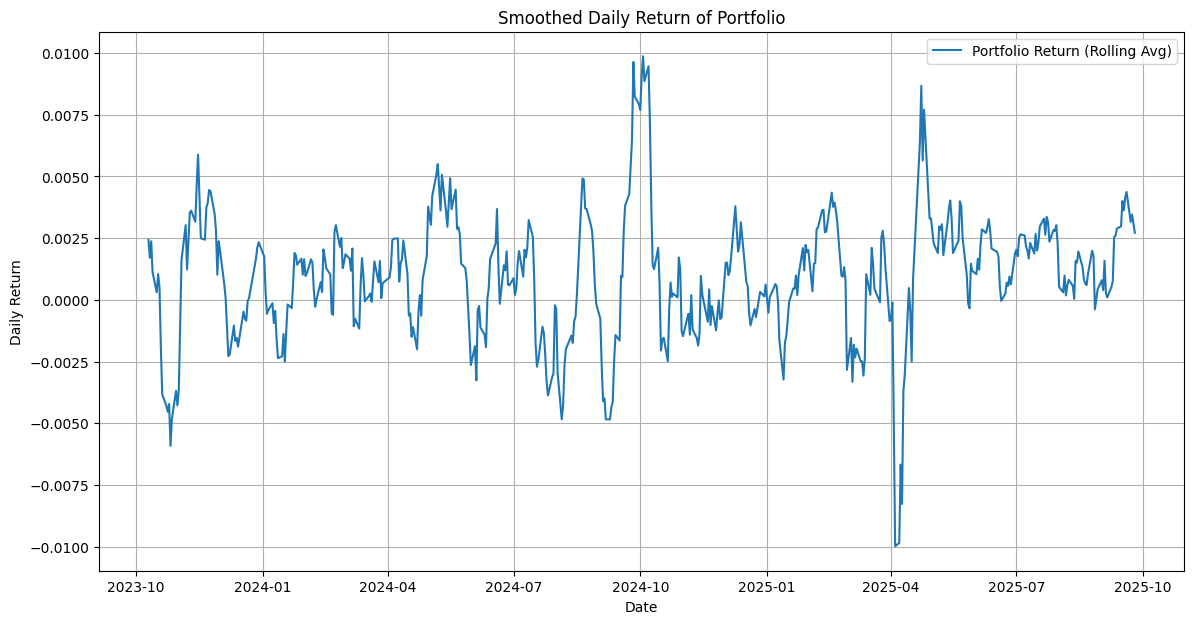

In [387]:
# Calculate daily percentage change for each asset
returns = df[['CTOP50.JO', 'ETF5IT.JO', 'STXCHN.JO', 'STXRAF.JO']].pct_change()

# Average the daily returns to get portfolio return
ports = returns.mean(axis=1)

# Apply rolling average to smooth the line
rolling = 10
ports_rolling = ports.rolling(rolling).mean()

# Plotting
plt.figure(figsize=(14,7))
plt.plot(df.index, ports_rolling, label='Portfolio Return (Rolling Avg)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Smoothed Daily Return of Portfolio')
plt.legend()
plt.show()


<Axes: >

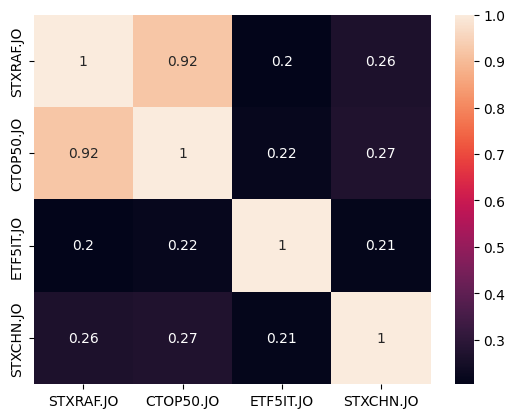

In [388]:
# correlation between returns
sb.heatmap(df.pct_change().corr(), annot=True)


In [389]:
# portfolio's total return
portfolio.pct_change().dropna().sum()*100

,0
Open,0.0
High,0.0
Low,0.0
Close,0.0
Volume,0.0
Dividends,0.0
Stock Splits,0.0


In [390]:
df.pct_change().sum()*100

,0
STXRAF.JO,40.076778
CTOP50.JO,37.822863
ETF5IT.JO,61.697254
STXCHN.JO,44.288784


<Axes: >

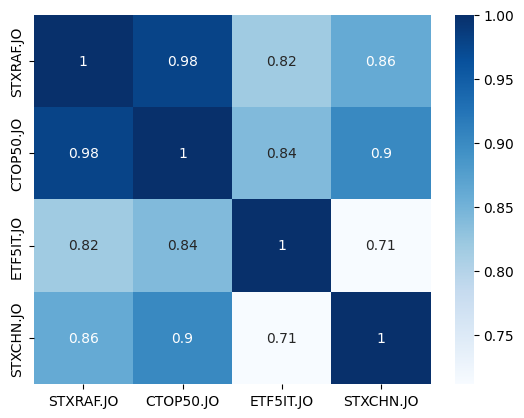

In [391]:
# correlation between the portfolio assets
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [392]:
def calculate_returns(price_data):
    return price_data.pct_change().dropna()

def portfolio_metrics(weights, returns):
    weights = np.array(weights)
    # Expected returns (mean of daily returns)
    mean_returns = returns.mean()
    # Covariance matrix
    cov_matrix = returns.cov()
    # Portfolio expected return
    port_return = np.dot(weights, mean_returns)
    return {
        "Expected Return (daily)": port_return,
    }


# 2. Calculate returns
returns = calculate_returns(df)

# 3. Define portfolio weights (must sum to 1)
weights = [current_prices[0]/np.sum(current_prices),current_prices[1]/np.sum(current_prices),
           current_prices[2]/np.sum(current_prices),current_prices[3]/np.sum(current_prices)]

# 4. Calculate portfolio metrics
results = portfolio_metrics(weights, returns)
annual_return = results["Expected Return (daily)"] * 252 * 100


In [393]:
# Drift independent volatility estimation

    # Overnight (Close-to-Open) returns
overnight_returns = np.log(portfolio['Open'] / portfolio['Close'].shift(1)).dropna()
var_overnight = overnight_returns.var(ddof=1)

    # Intraday (Open-to-Close) returns
intraday_returns = np.log(portfolio['Close'] / portfolio['Open']).dropna()
var_intraday = intraday_returns.var(ddof=1)

    # Rogers-Satchell volatility
log_hi_open = np.log(portfolio['High'] / portfolio['Open'])
log_hi_close = np.log(portfolio['High'] / portfolio['Close'])
log_lo_open = np.log(portfolio['Low'] / portfolio['Open'])
log_lo_close = np.log(portfolio['Low'] / portfolio['Close'])
rs_terms = log_hi_open * log_hi_close + log_lo_open * log_lo_close
var_rs = rs_terms.mean()
window = len(portfolio['Close'])
k = 0.34 / (1.34 + (window + 1) / (window - 1))

sigma_oc = intraday_returns.var()
sigma_co = overnight_returns.var()
sigma_rs = rs_terms.mean()

    # Yang-Zhang variance
yz_var = sigma_co + k * sigma_oc + (1 - k) * sigma_rs

annual_std = np.sqrt(yz_var)* np.sqrt(252)

In [397]:
print("Optimal Weights:", weights[0],weights[1],weights[2],weights[3])
print("Annualized Return:", round(annual_return, 4))
print("Annualized Std Dev:", round(annual_std, 4))
print("Portfolio Expected Daily Return:", round(results["Expected Return (daily)"], 6))


Optimal Weights: 0.19160328567082446 0.25555217523577733 0.20961362944934595 0.34323090964405234
Annualized Return: 22.9671
Annualized Std Dev: 0.2321
Portfolio Expected Daily Return: 0.000911


In [396]:
# Monte carlo simulation
# 1. Simulation Parameters

monthly_contribution = 1000
investment_months = 24
n_simulations = 10000
initial_value = 0
distribution = []
for i in range(len(weights)):
  con = weights[0+i] * 1000
  distribution.append(con)

# Example daily return and volatility (adjust as needed)
daily_return = results["Expected Return (daily)"]
daily_volatility = np.sqrt(yz_var)

# Convert to monthly
monthly_return = (1 + daily_return)**21 - 1
monthly_volatility = daily_volatility * np.sqrt(21)

# 2. Simulate Cumulative Portfolio Paths
np.random.seed(42)
portfolio_paths = np.zeros((n_simulations, investment_months + 1))

for i in range(n_simulations):
    monthly_returns = np.random.normal(monthly_return, monthly_volatility, investment_months)
    value = initial_value
    portfolio_paths[i, 0] = value  # Month 0
    for j in range(investment_months):
        value = (value + monthly_contribution) * (1 + monthly_returns[j])
        portfolio_paths[i, j + 1] = value

# 3. Final Portfolio Stats
final_values = portfolio_paths[:, -1]
mean_final = final_values.mean()
std_final = final_values.std(ddof=1)
total_contributed = initial_value + monthly_contribution * investment_months

# 4. 95% Confidence Interval (t-distribution)
dof = n_simulations - 1
t_crit = t.ppf(0.975, dof)
std_error = std_final / np.sqrt(n_simulations)

ci_lower = mean_final - t_crit * std_error
ci_upper = mean_final + t_crit * std_error

# 5. Output Results
print("Cumulative Portfolio Simulation Results")
print(f"Mean Final Value: R{mean_final:.2f}")
print(f"Total Contributed: R{total_contributed:.2f}")
print(f"95% CI(t-distribution): [R{ci_lower:.2f}, R{ci_upper:.2f}]")
print(f"Distribution: STXRAF.JO- R{distribution[0]:2f}, CTOP50.JO- R{distribution[1]:2f}, ETF5IT.JO- R{distribution[2]:2f}, STXCHN.JO- R{distribution[3]:2f}")

Cumulative Portfolio Simulation Results
Mean Final Value: R30792.42
Total Contributed: R24000.00
95% CI(t-distribution): [R30667.76, R30917.08]
Distribution: STXRAF.JO- R191.603286, CTOP50.JO- R255.552175, ETF5IT.JO- R209.613629, STXCHN.JO- R343.230910
